In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve, auc
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import time

In [5]:
data = loadmat('../datasets/musk.mat')

X = data['X']
y = data['y'].flatten()

print(f"Kształt X: {X.shape}")
print(f"Kształt y: {y.shape}")
print(f"Liczba normalnych (0): {np.sum(y == 0)}")
print(f"Liczba anomalii (1): {np.sum(y == 1)}")

Kształt X: (3062, 166)
Kształt y: (3062,)
Liczba normalnych (0): 2965
Liczba anomalii (1): 97


In [6]:

X_normal = X[y == 0]
y_normal = y[y == 0] 

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
    X_normal, y_normal, test_size=0.3, random_state=42
)

X_anomalies = X[y == 1]
y_anomalies = y[y == 1]
X_test = np.vstack([X_test_normal, X_anomalies])
y_test = np.hstack([y_test_normal, y_anomalies])

X_train = X_train_normal
y_train = y_train_normal

print(f"Zbiór treningowy: {X_train.shape[0]} próbek (wszystkie normalne)")
print(f"Zbiór testowy: {X_test.shape[0]} próbek ({np.sum(y_test == 0)} normalne, {np.sum(y_test == 1)} anomalie)")

Zbiór treningowy: 2075 próbek (wszystkie normalne)
Zbiór testowy: 987 próbek (890 normalne, 97 anomalie)


In [7]:
# Dopasowanie scalera do danych treningowych
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
def evaluate_model(model, X_train_scaled, X_test_scaled, y_test, verbose=True):
    # Trenowanie modelu i mierzenie czasu
    start_train_time = time.time()
    model.fit(X_train_scaled)
    train_time = time.time() - start_train_time
    
    # Przewidywanie na danych testowych i mierzenie czasu
    start_test_time = time.time()
    test_predictions = model.predict(X_test_scaled)
    test_scores = model.score_samples(X_test_scaled)
    test_time = time.time() - start_test_time
    
    # Mapowanie predykcji LOF: 1 -> 0 (normalne), -1 -> 1 (anomalie)
    test_predictions = np.where(test_predictions == 1, 0, 1)
    
    # Obliczanie metryk dla danych testowych
    precision = precision_score(y_test, test_predictions, pos_label=1)
    recall = recall_score(y_test, test_predictions, pos_label=1)
    f1 = f1_score(y_test, test_predictions, pos_label=1)
    fpr, tpr, _ = roc_curve(y_test, -test_scores)
    roc_auc = auc(fpr, tpr)
    
    if verbose:
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"AUC dla danych testowych: {roc_auc:.4f}")
        print(f"Czas trenowania: {train_time:.4f} s")
        print(f"Czas testowania: {test_time:.4f} s")
    
    # Zwracamy metryki w słowniku
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'train_time': train_time,
        'test_time': test_time,
        'fpr': fpr,
        'tpr': tpr
    }

In [9]:
import numpy as np
print(np.unique(y_test))

[0. 1.]


In [10]:
# Lista wartości n_neighbors do przetestowania
n_neighbors_list = [5, 10, 20, 30]

# Inicjalizacja listy na wyniki
results_list = []

# Pętla przez wartości n_neighbors
for n in n_neighbors_list:
    # Tworzenie modelu LOF
    lof = LocalOutlierFactor(n_neighbors=n, novelty=True)
    
    # Ocena modelu z wyłączonym wypisywaniem
    results = evaluate_model(lof, X_train_scaled, X_test_scaled, y_test, verbose=False)
    
    # Dodanie wartości n_neighbors do wyników
    results['n_neighbors'] = n
    
    # Zapisanie wyników
    results_list.append(results)

# Tworzenie DataFrame z wynikami
df_results = pd.DataFrame(results_list)

# Ustawienie kolejności kolumn
df_results = df_results[['n_neighbors', 'precision', 'recall', 'f1', 'roc_auc', 'train_time', 'test_time']]

# Wyświetlenie tabeli wyników
print("Wyniki dla różnych wartości n_neighbors:")
print(df_results)

Wyniki dla różnych wartości n_neighbors:
   n_neighbors  precision  recall        f1  roc_auc  train_time  test_time
0            5   0.989796     1.0  0.994872      1.0    0.203193   0.013542
1           10   1.000000     1.0  1.000000      1.0    0.016022   0.017162
2           20   1.000000     1.0  1.000000      1.0    0.018169   0.020705
3           30   1.000000     1.0  1.000000      1.0    0.018157   0.020025



LOF: n_neighbors=5, contamination=0.01
Precision: 0.9151
Recall: 1.0000
F1-score: 0.9557
AUC dla danych testowych: 1.0000
Czas trenowania: 0.0175 s
Czas testowania: 0.0167 s

LOF: n_neighbors=5, contamination=0.05
Precision: 0.6690
Recall: 1.0000
F1-score: 0.8017
AUC dla danych testowych: 1.0000
Czas trenowania: 0.0131 s
Czas testowania: 0.0119 s

LOF: n_neighbors=5, contamination=0.1
Precision: 0.4350
Recall: 1.0000
F1-score: 0.6062
AUC dla danych testowych: 1.0000
Czas trenowania: 0.0126 s
Czas testowania: 0.0140 s

LOF: n_neighbors=10, contamination=0.01
Precision: 0.9238
Recall: 1.0000
F1-score: 0.9604
AUC dla danych testowych: 1.0000
Czas trenowania: 0.0170 s
Czas testowania: 0.0146 s

LOF: n_neighbors=10, contamination=0.05
Precision: 0.7239
Recall: 1.0000
F1-score: 0.8398
AUC dla danych testowych: 1.0000
Czas trenowania: 0.0156 s
Czas testowania: 0.0160 s

LOF: n_neighbors=10, contamination=0.1
Precision: 0.4924
Recall: 1.0000
F1-score: 0.6599
AUC dla danych testowych: 1.0000
C

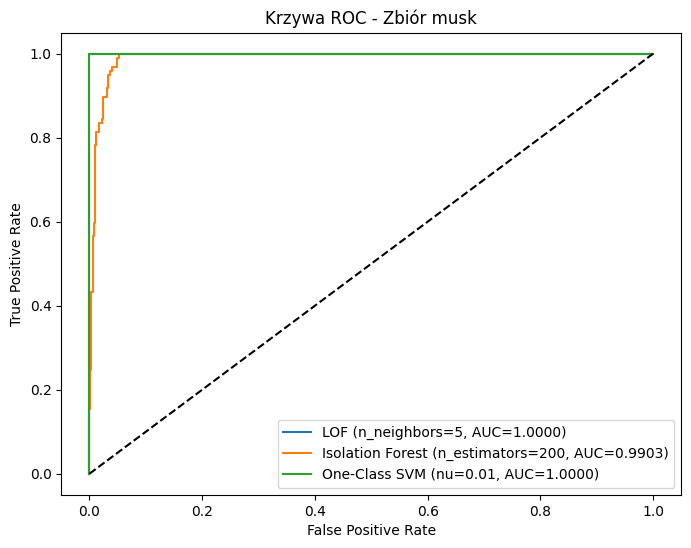

In [11]:
# 1. Strojenie parametrów dla LOF
n_neighbors_list = [5, 10, 20, 30]
contamination_list = [0.01, 0.05, 0.1]
lof_results = []

for n_neighbors in n_neighbors_list:
    for contamination in contamination_list:
        print(f"\nLOF: n_neighbors={n_neighbors}, contamination={contamination}")
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=True)
        results = evaluate_model(lof, X_train_scaled, X_test_scaled, y_test, verbose=True)
        results['model'] = 'LOF'
        results['n_neighbors'] = n_neighbors
        results['contamination'] = contamination
        lof_results.append(results)

# 2. Strojenie parametrów dla Isolation Forest
n_estimators_list = [50, 100, 200]
contamination_list = [0.01, 0.05, 0.1]
iso_results = []

for n_estimators in n_estimators_list:
    for contamination in contamination_list:
        print(f"\nIsolation Forest: n_estimators={n_estimators}, contamination={contamination}")
        iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)
        results = evaluate_model(iso_forest, X_train_scaled, X_test_scaled, y_test, verbose=True)
        results['model'] = 'Isolation Forest'
        results['n_estimators'] = n_estimators
        results['contamination'] = contamination
        iso_results.append(results)

# 3. Strojenie parametrów dla One-Class SVM
nu_list = [0.01, 0.05, 0.1, 0.2]
gamma_list = [0.001, 0.01, 'scale']
svm_results = []

for nu in nu_list:
    for gamma in gamma_list:
        print(f"\nOne-Class SVM: nu={nu}, gamma={gamma}")
        ocsvm = OneClassSVM(nu=nu, gamma=gamma, kernel='rbf')
        results = evaluate_model(ocsvm, X_train_scaled, X_test_scaled, y_test, verbose=True)
        results['model'] = 'One-Class SVM'
        results['nu'] = nu
        results['gamma'] = gamma
        svm_results.append(results)

# 4. Zapis wyników do DataFrame
all_results = lof_results + iso_results + svm_results
results_df = pd.DataFrame(all_results)

# Usuń kolumny fpr i tpr z DataFrame, aby tabela była czytelna
results_df = results_df.drop(columns=['fpr', 'tpr'])

# Wyświetl wyniki
print("\nWyniki dla wszystkich modeli:")
print(results_df)

# 5. Wykres ROC dla najlepszych modeli
plt.figure(figsize=(8, 6))

# Wybierz najlepszy model dla każdej metody (na podstawie AUC)
best_lof = max(lof_results, key=lambda x: x['roc_auc'])
best_iso = max(iso_results, key=lambda x: x['roc_auc'])
best_svm = max(svm_results, key=lambda x: x['roc_auc'])

plt.plot(best_lof['fpr'], best_lof['tpr'], label=f"LOF (n_neighbors={best_lof['n_neighbors']}, AUC={best_lof['roc_auc']:.4f})")
plt.plot(best_iso['fpr'], best_iso['tpr'], label=f"Isolation Forest (n_estimators={best_iso['n_estimators']}, AUC={best_iso['roc_auc']:.4f})")
plt.plot(best_svm['fpr'], best_svm['tpr'], label=f"One-Class SVM (nu={best_svm['nu']}, AUC={best_svm['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Zbiór musk')
plt.legend()
plt.show()